# Building Input Pipeline for train and test data

In [4]:
import numpy as np 
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import os
import xml.dom.minidom
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#source :- https://www.tensorflow.org/api_docs/python/tf/data/Dataset

height , width = 1024 , 1024 #size to which input image needs to resize

def mapping(file_path):

  table_path = tf.strings.regex_replace(file_path, 'marmots_usuals', 'marmot_table')
  column_path = tf.strings.regex_replace(file_path, 'marmots_usuals', 'marmot_column')

  table_path = tf.strings.regex_replace(table_path, '.jpeg', '.bmp_table.jpeg')
  column_path = tf.strings.regex_replace(column_path, '.jpeg', '.bmp_col.jpeg')
  

  #reading  , resizing and normalizing for image data
  images = tf.io.read_file(file_path)
  images = tf.image.decode_jpeg(images, channels=3) #Decode a JPEG-encoded image to a uint8 tensor
  images = tf.cast(images, tf.float32) / 255.0 # normalizing image

  #reading  , resizing and normalizing for table mask data
  table_mask = tf.io.read_file(table_path)
  table_mask = tf.image.decode_jpeg(table_mask, channels=1) 
  table_mask = tf.image.resize(table_mask, [height, width]) #resizing image to input shape of model
  table_mask = tf.cast(table_mask, tf.float32) / 255.0 

  #reading  , resizing and normalizing for column mask data
  column_mask = tf.io.read_file(column_path)
  column_mask = tf.image.decode_jpeg(column_mask, channels=1) 
  column_mask = tf.image.resize(column_mask, [height, width]) 
  column_mask = tf.cast(column_mask, tf.float32) / 255.0 

  return images, {"table_mask" : table_mask, "column_mask" : column_mask }

def data_pipeline(dataset, input , batch_size = 1):
  #how many parallel call need to be done , so left tensor to decide
  autotune = tf.data.experimental.AUTOTUNE

  if input == 'train':
    #length of file list
    total_size = len(list(dataset))

    #proportion of file to be fetched for train 
    proportion = 0.9
    input_data_size = int(proportion * total_size)
    
    #fetching data for input
    input_data = dataset.take(input_data_size)
    
    #mapping file from input data
    input_data = input_data.map(mapping,num_parallel_calls=autotune)
    train_data = input_data

    #kepping track of inital loaded data in the memory to speed up the the process for next iteration 
    input_data = input_data.cache()

    #Randomly shuffles the elements for the given dataset
    buffer_size =  input_data_size # randomly samples elements from this buffer, replacing the selected elements with new elements
    input_data = input_data.shuffle(buffer_size)

    #creating input file in batch 
    input_data = input_data.batch(batch_size)

    # to re-initialize the input_data
    input_data = input_data.repeat()

    #delivers data for the next step before the current step has finished
    input_data = input_data.prefetch(buffer_size=autotune)

    return input_data , train_data

  else:
    #length of file list
    total_size = len(list(dataset))

    #proportion of file to be fetched for train and test
    proportion = 0.9
    input_data_size = int(proportion * total_size)
    
    #fetching data for input
    input_data = dataset.skip(input_data_size)
    
    #mapping file from input data
    input_data = input_data.map(mapping,num_parallel_calls=autotune)
    test_data = input_data

    #Randomly shuffles the elements for the given dataset
    buffer_size =  input_data_size 
    input_data = input_data.shuffle(buffer_size)

    #creating input file in batch 
    input_data = input_data.batch(batch_size)

    return input_data , test_data



In [ ]:
#Create a source dataset from given  input data
#dataset = tf.data.Dataset.list_files("/content/content/Shareddrives/my_drive/input/CHK1/data/marmots_1024/*.jpeg")
dataset = tf.data.Dataset.list_files("/content/content/MyDrive/table_extraction/marmots_usuals/*.jpeg")

train_dataloader , train_data = data_pipeline(dataset, 'train' , batch_size = 1)
test_dataloader , test_data= data_pipeline(dataset, 'test' , batch_size = 1)


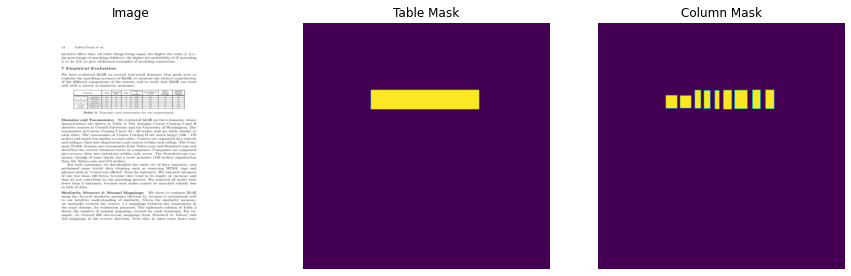

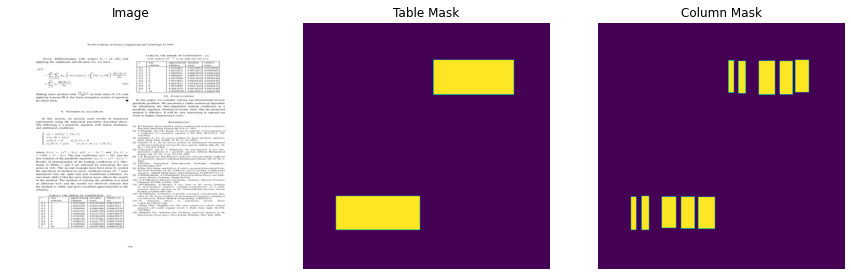

In [ ]:
number = 2
for image, mask  in test_data.take(number):
  plt.figure(figsize=(15, 15))
  lists = [image, mask['table_mask'], mask['column_mask']]
  title = ['Image', 'Table Mask', 'Column Mask']         
  for i in range(len(lists)):
    plt.subplot(1, len(lists), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(lists[i]))
    plt.axis('off')
  plt.show()         

In [20]:
#input size for all image should be 1024 * 1024 with three channels
inputShape = (1024, 1024, 3)
inputs = Input(shape=inputShape, name='input')

#importing  pre trained VGG19 model till to bottle neck
vgg_19=tf.keras.applications.VGG19(input_tensor=inputs,include_top=False, weights='imagenet', pooling=None, classes=1000)

#addding 2 (1 * 1) convolutional layers followed by dropot eith 80%
x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(vgg_19.output)
x = Dropout(0.8, name='block6_dropout1')(x)
x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
x = Dropout(0.8, name = 'block6_dropout2')(x)


#taking 3rd and 4th maxpool layer from vgg_19 for decoders
block3_pool=vgg_19.get_layer('block3_pool').output
block4_pool=vgg_19.get_layer('block4_pool').output

80142336/80134624 [==============================] - 0s 0us/step


In [21]:
class table_decoder(tf.keras.layers.Layer):
    def __init__(self, name="table_mask"):
        super().__init__(name=name)
        self.conv1 = Conv2D(filters =512,kernel_size = (1, 1), activation = 'relu')
        self.upsample1 = UpSampling2D(size=(2, 2))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2,2))
        self.upsample4 = UpSampling2D(size=(2,2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2,padding='same')

        
    def call(self, X):
      input , pool_3, pool_4 = X[0] , X[1], X[2]


      result = self.conv1(input)
      result = self.upsample1(result)
      result = Concatenate()([result,pool_4])
      result = self.upsample2(result)
      result = Concatenate()([result,pool_3])
      result = self.upsample3(result)
      result = self.upsample4(result)
      result = self.convtraspose(result)

      return result


In [22]:
class column_decoder(tf.keras.layers.Layer):
    def __init__(self, name="column_mask"):
        super().__init__(name=name)
        self.conv1 = Conv2D(filters =512,kernel_size = (1, 1), activation = 'relu')
        self.drop = Dropout(0.8)
        self.conv2 = Conv2D(filters =512,kernel_size = (1, 1), activation = 'relu')
        self.upsample1 = UpSampling2D(size=(2, 2))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2,2))
        self.upsample4 = UpSampling2D(size=(2,2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2,padding='same', name='column_mask')
        
    def call(self, X):
      input , pool_3, pool_4 = X[0] , X[1], X[2]

      result = self.conv1(input)
      result = self.drop(result)
      result = self.conv2(result)
      result = self.upsample1(result)
      result = Concatenate()([result,pool_4])
      result = self.upsample2(result)
      result = Concatenate()([result,pool_3])
      result = self.upsample3(result)
      result = self.upsample4(result)
      result = self.convtraspose(result)
      return result

In [23]:
encoder_result = [x,block3_pool,block4_pool]

Table_Decoder = table_decoder()
Column_Decoder = column_decoder()

output1 = Table_Decoder(encoder_result)
output2 = Column_Decoder(encoder_result)

In [24]:
model = Model(inputs=inputs,outputs=[output1, output2],name="tablenet")

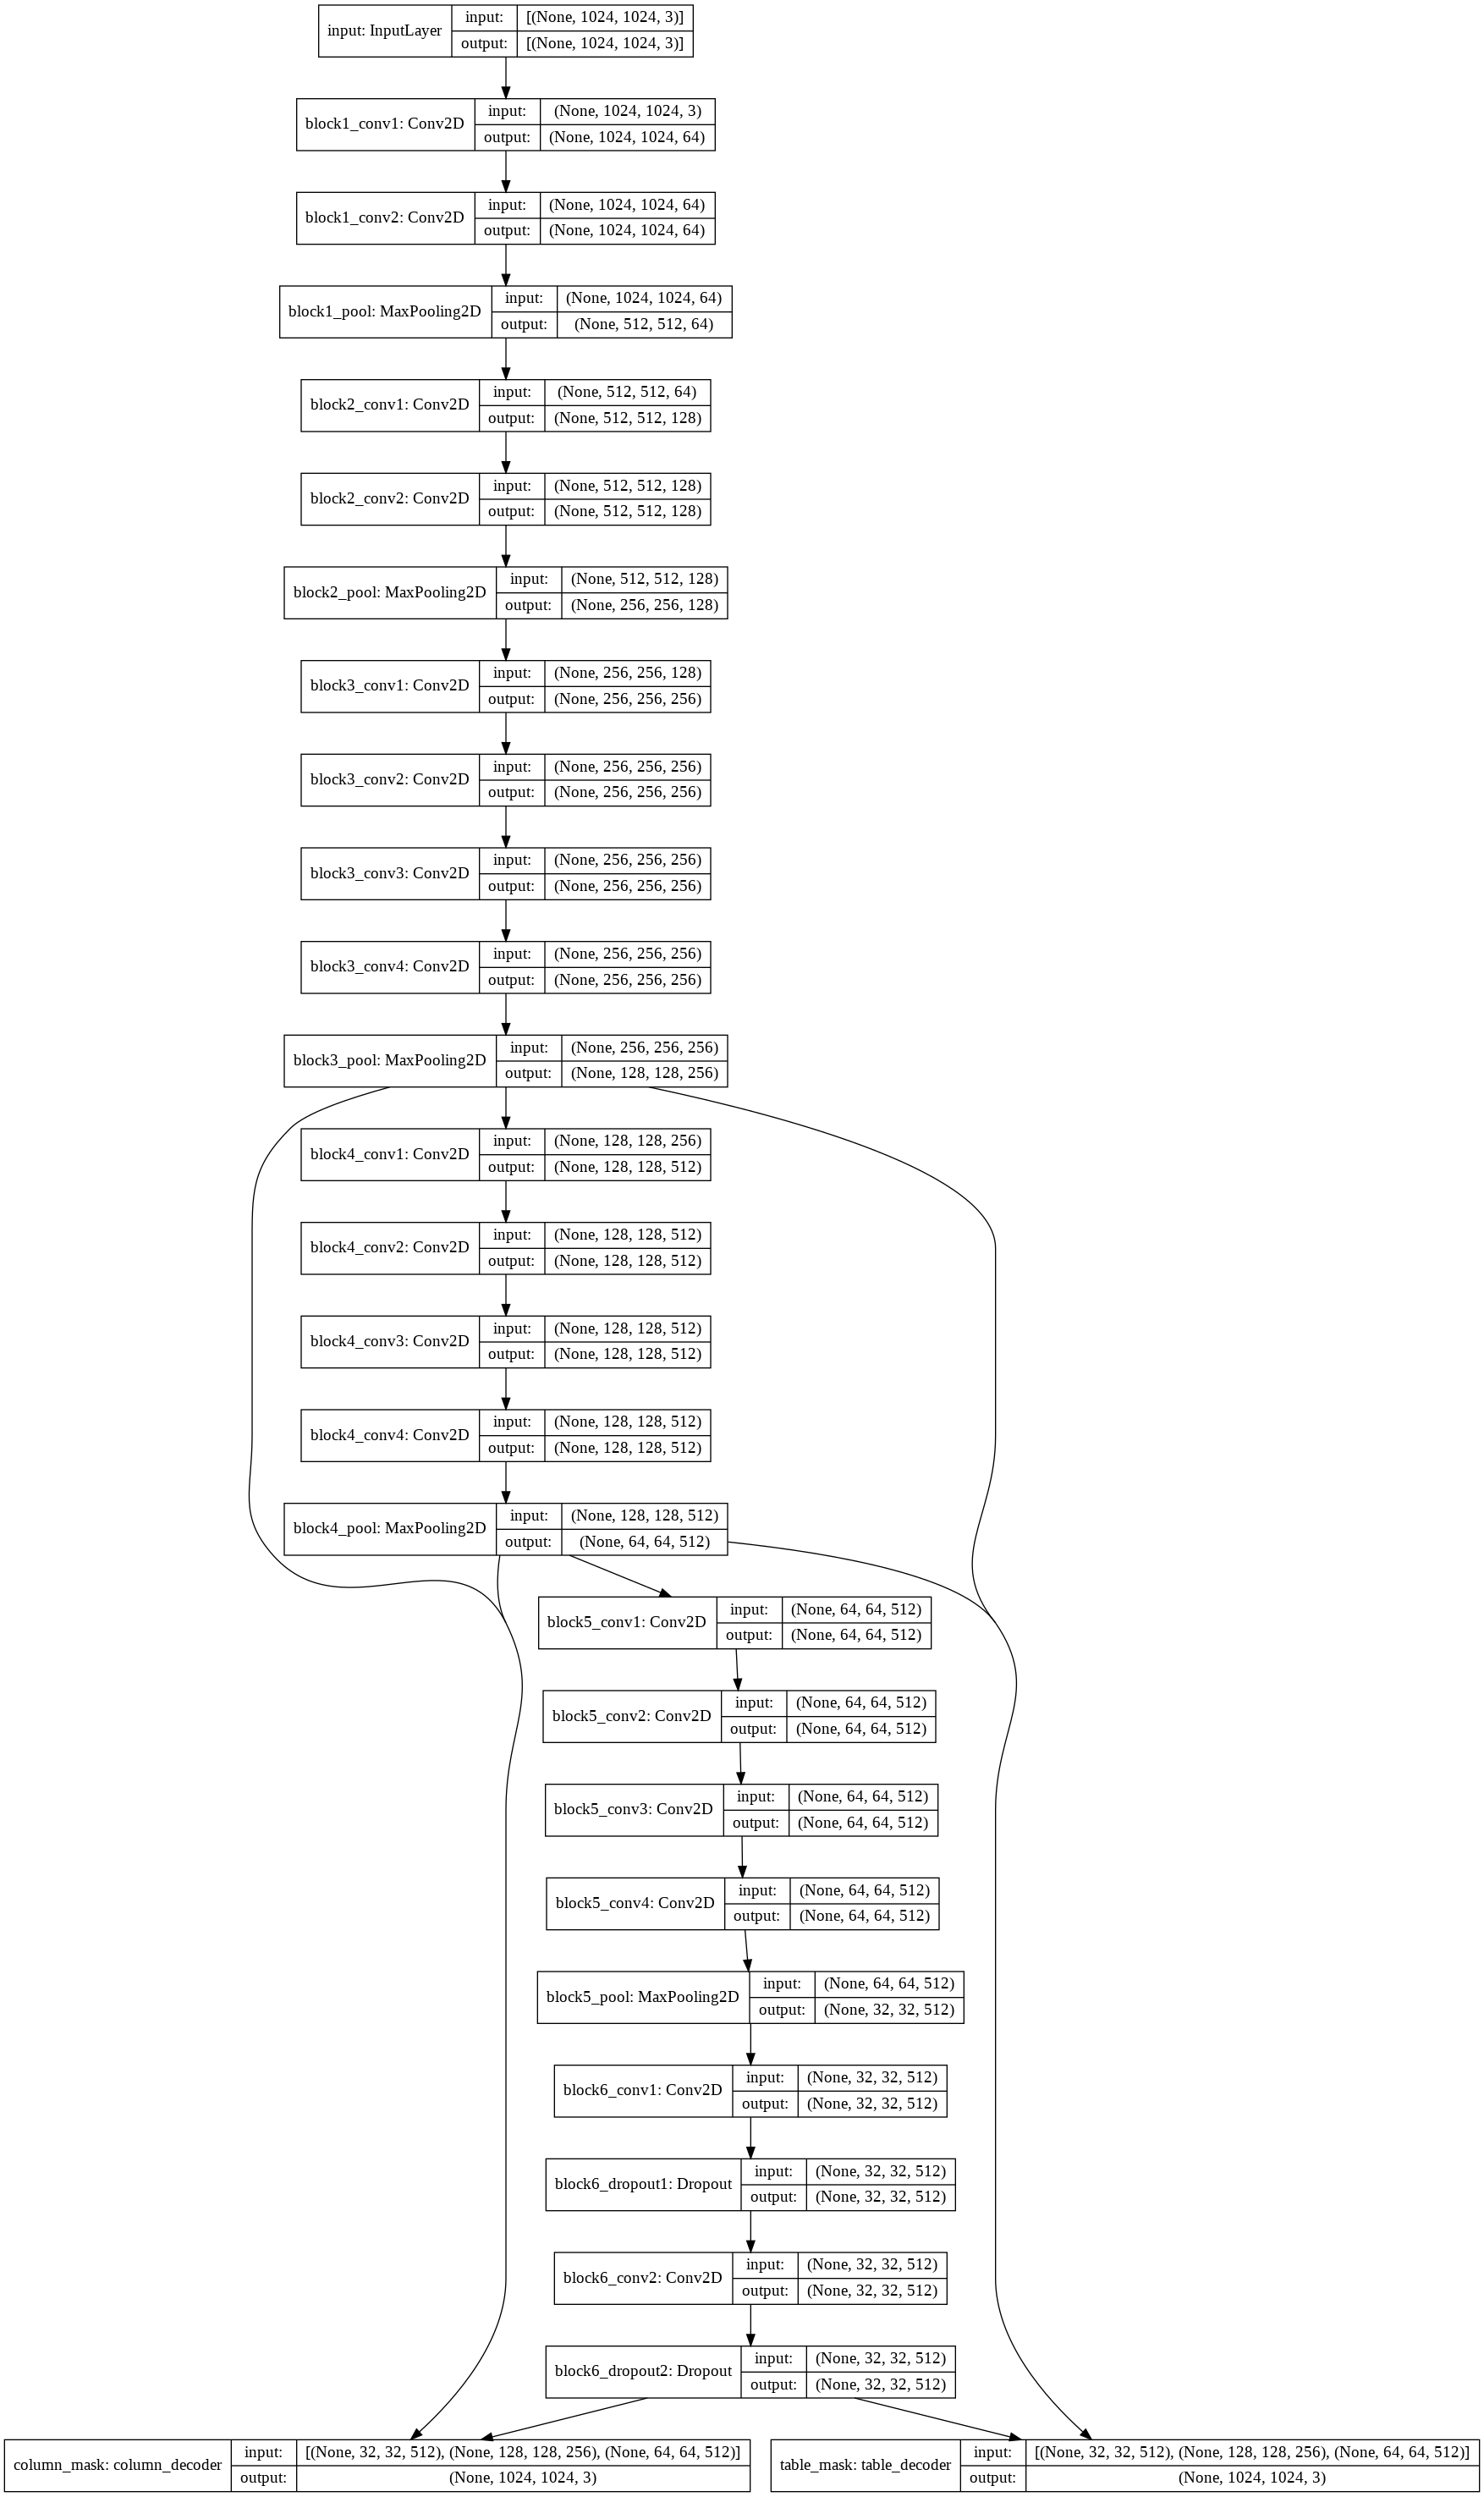

In [25]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
model.summary()

Model: "tablenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 1024, 1024, 6 1792        input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 1024, 1024, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 512, 512, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [ ]:
losses = {
    "table_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "column_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table_mask": 1.0, "column_mask": 1.0}

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
    )

In [ ]:
batch_size = 1
model_history = model.fit(train_dataloader, epochs=200,
                          steps_per_epoch=len(train_data)//batch_size,
                          validation_steps=len(test_data)//batch_size,
                          validation_data=test_dataloader, callbacks=model_checkpoint
                         )

Epoch 1/200
435/435 [==============================] - 165s 344ms/step - loss: 0.8558 - table_mask_loss: 0.4653 - column_mask_loss: 0.3905 - table_mask_accuracy: 0.8450 - column_mask_accuracy: 0.8605 - val_loss: 0.8162 - val_table_mask_loss: 0.4190 - val_column_mask_loss: 0.3972 - val_table_mask_accuracy: 0.8629 - val_column_mask_accuracy: 0.8832

Epoch 00001: val_loss improved from inf to 0.81620, saving model to mymodel_1


INFO:tensorflow:Assets written to: mymodel_1/assets


INFO:tensorflow:Assets written to: mymodel_1/assets


Epoch 2/200
435/435 [==============================] - 149s 343ms/step - loss: 0.4773 - table_mask_loss: 0.2486 - column_mask_loss: 0.2286 - table_mask_accuracy: 0.8976 - column_mask_accuracy: 0.8921 - val_loss: 0.3968 - val_table_mask_loss: 0.1814 - val_column_mask_loss: 0.2154 - val_table_mask_accuracy: 0.9271 - val_column_mask_accuracy: 0.9041

Epoch 00002: val_loss improved from 0.81620 to 0.39680, saving model to mymodel_2


INFO:tensorflow:Assets written to: mymodel_2/assets


INFO:tensorflow:Assets written to: mymodel_2/assets


Epoch 3/200
435/435 [==============================] - 149s 343ms/step - loss: 0.3640 - table_mask_loss: 0.1868 - column_mask_loss: 0.1772 - table_mask_accuracy: 0.9219 - column_mask_accuracy: 0.9042 - val_loss: 0.6511 - val_table_mask_loss: 0.2741 - val_column_mask_loss: 0.3770 - val_table_mask_accuracy: 0.9004 - val_column_mask_accuracy: 0.8715

Epoch 00003: val_loss did not improve from 0.39680
Epoch 4/200
435/435 [==============================] - 149s 343ms/step - loss: 0.3202 - table_mask_loss: 0.1607 - column_mask_loss: 0.1596 - table_mask_accuracy: 0.9317 - column_mask_accuracy: 0.9119 - val_loss: 0.5493 - val_table_mask_loss: 0.2023 - val_column_mask_loss: 0.3471 - val_table_mask_accuracy: 0.9346 - val_column_mask_accuracy: 0.8979

Epoch 00004: val_loss did not improve from 0.39680
Epoch 5/200
435/435 [==============================] - 149s 343ms/step - loss: 0.2679 - table_mask_loss: 0.1297 - column_mask_loss: 0.1382 - table_mask_accuracy: 0.9456 - column_mask_accuracy: 0.922

INFO:tensorflow:Assets written to: mymodel_44/assets


INFO:tensorflow:Assets written to: mymodel_44/assets


Epoch 45/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0810 - table_mask_loss: 0.0264 - column_mask_loss: 0.0545 - table_mask_accuracy: 0.9791 - column_mask_accuracy: 0.9496 - val_loss: 0.5922 - val_table_mask_loss: 0.4361 - val_column_mask_loss: 0.1561 - val_table_mask_accuracy: 0.7890 - val_column_mask_accuracy: 0.9067

Epoch 00045: val_loss did not improve from 0.35362
Epoch 46/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0777 - table_mask_loss: 0.0243 - column_mask_loss: 0.0533 - table_mask_accuracy: 0.9791 - column_mask_accuracy: 0.9486 - val_loss: 0.4299 - val_table_mask_loss: 0.3328 - val_column_mask_loss: 0.0971 - val_table_mask_accuracy: 0.8365 - val_column_mask_accuracy: 0.9431

Epoch 00046: val_loss did not improve from 0.35362
Epoch 47/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0844 - table_mask_loss: 0.0279 - column_mask_loss: 0.0565 - table_mask_accuracy: 0.9783 - column_mask_accuracy: 0.

INFO:tensorflow:Assets written to: mymodel_54/assets


INFO:tensorflow:Assets written to: mymodel_54/assets


Epoch 55/200
435/435 [==============================] - 149s 344ms/step - loss: 0.0637 - table_mask_loss: 0.0198 - column_mask_loss: 0.0440 - table_mask_accuracy: 0.9815 - column_mask_accuracy: 0.9560 - val_loss: 0.4740 - val_table_mask_loss: 0.3970 - val_column_mask_loss: 0.0770 - val_table_mask_accuracy: 0.7977 - val_column_mask_accuracy: 0.9429

Epoch 00055: val_loss did not improve from 0.32459
Epoch 56/200
435/435 [==============================] - 150s 344ms/step - loss: 0.0658 - table_mask_loss: 0.0201 - column_mask_loss: 0.0458 - table_mask_accuracy: 0.9809 - column_mask_accuracy: 0.9526 - val_loss: 0.4470 - val_table_mask_loss: 0.3525 - val_column_mask_loss: 0.0945 - val_table_mask_accuracy: 0.8417 - val_column_mask_accuracy: 0.9347

Epoch 00056: val_loss did not improve from 0.32459
Epoch 57/200
435/435 [==============================] - 150s 344ms/step - loss: 0.0680 - table_mask_loss: 0.0215 - column_mask_loss: 0.0465 - table_mask_accuracy: 0.9810 - column_mask_accuracy: 0.

INFO:tensorflow:Assets written to: mymodel_60/assets


INFO:tensorflow:Assets written to: mymodel_60/assets


Epoch 61/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0888 - table_mask_loss: 0.0294 - column_mask_loss: 0.0593 - table_mask_accuracy: 0.9781 - column_mask_accuracy: 0.9480 - val_loss: 0.2973 - val_table_mask_loss: 0.2236 - val_column_mask_loss: 0.0736 - val_table_mask_accuracy: 0.9106 - val_column_mask_accuracy: 0.9521

Epoch 00061: val_loss improved from 0.31304 to 0.29728, saving model to mymodel_61


INFO:tensorflow:Assets written to: mymodel_61/assets


INFO:tensorflow:Assets written to: mymodel_61/assets


Epoch 62/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0702 - table_mask_loss: 0.0222 - column_mask_loss: 0.0479 - table_mask_accuracy: 0.9804 - column_mask_accuracy: 0.9528 - val_loss: 0.3082 - val_table_mask_loss: 0.2420 - val_column_mask_loss: 0.0662 - val_table_mask_accuracy: 0.8974 - val_column_mask_accuracy: 0.9501

Epoch 00062: val_loss did not improve from 0.29728
Epoch 63/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0690 - table_mask_loss: 0.0211 - column_mask_loss: 0.0479 - table_mask_accuracy: 0.9802 - column_mask_accuracy: 0.9506 - val_loss: 0.1918 - val_table_mask_loss: 0.1282 - val_column_mask_loss: 0.0637 - val_table_mask_accuracy: 0.9539 - val_column_mask_accuracy: 0.9466

Epoch 00063: val_loss improved from 0.29728 to 0.19183, saving model to mymodel_63


INFO:tensorflow:Assets written to: mymodel_63/assets


INFO:tensorflow:Assets written to: mymodel_63/assets


Epoch 64/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0636 - table_mask_loss: 0.0198 - column_mask_loss: 0.0437 - table_mask_accuracy: 0.9810 - column_mask_accuracy: 0.9558 - val_loss: 0.3067 - val_table_mask_loss: 0.2182 - val_column_mask_loss: 0.0885 - val_table_mask_accuracy: 0.9147 - val_column_mask_accuracy: 0.9401

Epoch 00064: val_loss did not improve from 0.19183
Epoch 65/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0625 - table_mask_loss: 0.0183 - column_mask_loss: 0.0443 - table_mask_accuracy: 0.9812 - column_mask_accuracy: 0.9529 - val_loss: 0.2472 - val_table_mask_loss: 0.1878 - val_column_mask_loss: 0.0594 - val_table_mask_accuracy: 0.9087 - val_column_mask_accuracy: 0.9486

Epoch 00065: val_loss did not improve from 0.19183
Epoch 66/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0635 - table_mask_loss: 0.0198 - column_mask_loss: 0.0438 - table_mask_accuracy: 0.9810 - column_mask_accuracy: 0.

INFO:tensorflow:Assets written to: mymodel_73/assets


INFO:tensorflow:Assets written to: mymodel_73/assets


Epoch 74/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0550 - table_mask_loss: 0.0164 - column_mask_loss: 0.0386 - table_mask_accuracy: 0.9819 - column_mask_accuracy: 0.9563 - val_loss: 0.2367 - val_table_mask_loss: 0.1717 - val_column_mask_loss: 0.0650 - val_table_mask_accuracy: 0.9141 - val_column_mask_accuracy: 0.9480

Epoch 00074: val_loss did not improve from 0.18232
Epoch 75/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0537 - table_mask_loss: 0.0166 - column_mask_loss: 0.0371 - table_mask_accuracy: 0.9815 - column_mask_accuracy: 0.9568 - val_loss: 0.1819 - val_table_mask_loss: 0.1167 - val_column_mask_loss: 0.0652 - val_table_mask_accuracy: 0.9575 - val_column_mask_accuracy: 0.9518

Epoch 00075: val_loss improved from 0.18232 to 0.18191, saving model to mymodel_75


INFO:tensorflow:Assets written to: mymodel_75/assets


INFO:tensorflow:Assets written to: mymodel_75/assets


Epoch 76/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0523 - table_mask_loss: 0.0161 - column_mask_loss: 0.0362 - table_mask_accuracy: 0.9820 - column_mask_accuracy: 0.9568 - val_loss: 0.1519 - val_table_mask_loss: 0.1045 - val_column_mask_loss: 0.0474 - val_table_mask_accuracy: 0.9601 - val_column_mask_accuracy: 0.9582

Epoch 00076: val_loss improved from 0.18191 to 0.15189, saving model to mymodel_76


INFO:tensorflow:Assets written to: mymodel_76/assets


INFO:tensorflow:Assets written to: mymodel_76/assets


Epoch 77/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0526 - table_mask_loss: 0.0164 - column_mask_loss: 0.0362 - table_mask_accuracy: 0.9815 - column_mask_accuracy: 0.9555 - val_loss: 0.1943 - val_table_mask_loss: 0.1394 - val_column_mask_loss: 0.0549 - val_table_mask_accuracy: 0.9463 - val_column_mask_accuracy: 0.9595

Epoch 00077: val_loss did not improve from 0.15189
Epoch 78/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0593 - table_mask_loss: 0.0187 - column_mask_loss: 0.0406 - table_mask_accuracy: 0.9812 - column_mask_accuracy: 0.9554 - val_loss: 0.9487 - val_table_mask_loss: 0.7842 - val_column_mask_loss: 0.1645 - val_table_mask_accuracy: 0.6533 - val_column_mask_accuracy: 0.9223

Epoch 00078: val_loss did not improve from 0.15189
Epoch 79/200
435/435 [==============================] - 149s 343ms/step - loss: 0.1525 - table_mask_loss: 0.0669 - column_mask_loss: 0.0855 - table_mask_accuracy: 0.9662 - column_mask_accuracy: 0.

INFO:tensorflow:Assets written to: mymodel_82/assets


INFO:tensorflow:Assets written to: mymodel_82/assets


Epoch 83/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0527 - table_mask_loss: 0.0161 - column_mask_loss: 0.0366 - table_mask_accuracy: 0.9820 - column_mask_accuracy: 0.9552 - val_loss: 0.1701 - val_table_mask_loss: 0.0988 - val_column_mask_loss: 0.0713 - val_table_mask_accuracy: 0.9566 - val_column_mask_accuracy: 0.9467

Epoch 00083: val_loss did not improve from 0.12945
Epoch 84/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0500 - table_mask_loss: 0.0152 - column_mask_loss: 0.0348 - table_mask_accuracy: 0.9821 - column_mask_accuracy: 0.9574 - val_loss: 0.1722 - val_table_mask_loss: 0.1168 - val_column_mask_loss: 0.0554 - val_table_mask_accuracy: 0.9337 - val_column_mask_accuracy: 0.9522

Epoch 00084: val_loss did not improve from 0.12945
Epoch 85/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0493 - table_mask_loss: 0.0155 - column_mask_loss: 0.0338 - table_mask_accuracy: 0.9813 - column_mask_accuracy: 0.

INFO:tensorflow:Assets written to: mymodel_86/assets


INFO:tensorflow:Assets written to: mymodel_86/assets


Epoch 87/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0497 - table_mask_loss: 0.0151 - column_mask_loss: 0.0346 - table_mask_accuracy: 0.9820 - column_mask_accuracy: 0.9573 - val_loss: 0.1507 - val_table_mask_loss: 0.0938 - val_column_mask_loss: 0.0569 - val_table_mask_accuracy: 0.9615 - val_column_mask_accuracy: 0.9563

Epoch 00087: val_loss did not improve from 0.12927
Epoch 88/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0502 - table_mask_loss: 0.0151 - column_mask_loss: 0.0351 - table_mask_accuracy: 0.9823 - column_mask_accuracy: 0.9559 - val_loss: 0.1639 - val_table_mask_loss: 0.0806 - val_column_mask_loss: 0.0833 - val_table_mask_accuracy: 0.9661 - val_column_mask_accuracy: 0.9482

Epoch 00088: val_loss did not improve from 0.12927
Epoch 89/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0624 - table_mask_loss: 0.0220 - column_mask_loss: 0.0404 - table_mask_accuracy: 0.9800 - column_mask_accuracy: 0.

INFO:tensorflow:Assets written to: mymodel_90/assets


INFO:tensorflow:Assets written to: mymodel_90/assets


Epoch 91/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0496 - table_mask_loss: 0.0157 - column_mask_loss: 0.0340 - table_mask_accuracy: 0.9816 - column_mask_accuracy: 0.9564 - val_loss: 0.1136 - val_table_mask_loss: 0.0622 - val_column_mask_loss: 0.0514 - val_table_mask_accuracy: 0.9723 - val_column_mask_accuracy: 0.9532

Epoch 00091: val_loss did not improve from 0.09938
Epoch 92/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0439 - table_mask_loss: 0.0138 - column_mask_loss: 0.0301 - table_mask_accuracy: 0.9829 - column_mask_accuracy: 0.9608 - val_loss: 0.1322 - val_table_mask_loss: 0.0818 - val_column_mask_loss: 0.0505 - val_table_mask_accuracy: 0.9698 - val_column_mask_accuracy: 0.9579

Epoch 00092: val_loss did not improve from 0.09938
Epoch 93/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0460 - table_mask_loss: 0.0140 - column_mask_loss: 0.0320 - table_mask_accuracy: 0.9824 - column_mask_accuracy: 0.

INFO:tensorflow:Assets written to: mymodel_93/assets


INFO:tensorflow:Assets written to: mymodel_93/assets


Epoch 94/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0656 - table_mask_loss: 0.0240 - column_mask_loss: 0.0416 - table_mask_accuracy: 0.9794 - column_mask_accuracy: 0.9548 - val_loss: 0.2336 - val_table_mask_loss: 0.1334 - val_column_mask_loss: 0.1003 - val_table_mask_accuracy: 0.9470 - val_column_mask_accuracy: 0.9320

Epoch 00094: val_loss did not improve from 0.08221
Epoch 95/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0712 - table_mask_loss: 0.0249 - column_mask_loss: 0.0462 - table_mask_accuracy: 0.9788 - column_mask_accuracy: 0.9526 - val_loss: 0.1160 - val_table_mask_loss: 0.0661 - val_column_mask_loss: 0.0499 - val_table_mask_accuracy: 0.9717 - val_column_mask_accuracy: 0.9562

Epoch 00095: val_loss did not improve from 0.08221
Epoch 96/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0499 - table_mask_loss: 0.0154 - column_mask_loss: 0.0345 - table_mask_accuracy: 0.9820 - column_mask_accuracy: 0.

INFO:tensorflow:Assets written to: mymodel_96/assets


INFO:tensorflow:Assets written to: mymodel_96/assets


Epoch 97/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0430 - table_mask_loss: 0.0135 - column_mask_loss: 0.0294 - table_mask_accuracy: 0.9828 - column_mask_accuracy: 0.9600 - val_loss: 0.1635 - val_table_mask_loss: 0.0834 - val_column_mask_loss: 0.0802 - val_table_mask_accuracy: 0.9649 - val_column_mask_accuracy: 0.9476

Epoch 00097: val_loss did not improve from 0.08066
Epoch 98/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0409 - table_mask_loss: 0.0127 - column_mask_loss: 0.0282 - table_mask_accuracy: 0.9832 - column_mask_accuracy: 0.9612 - val_loss: 0.1416 - val_table_mask_loss: 0.0677 - val_column_mask_loss: 0.0740 - val_table_mask_accuracy: 0.9727 - val_column_mask_accuracy: 0.9547

Epoch 00098: val_loss did not improve from 0.08066
Epoch 99/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0456 - table_mask_loss: 0.0136 - column_mask_loss: 0.0320 - table_mask_accuracy: 0.9825 - column_mask_accuracy: 0.

INFO:tensorflow:Assets written to: mymodel_106/assets


INFO:tensorflow:Assets written to: mymodel_106/assets


Epoch 107/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0523 - table_mask_loss: 0.0172 - column_mask_loss: 0.0351 - table_mask_accuracy: 0.9817 - column_mask_accuracy: 0.9574 - val_loss: 0.1206 - val_table_mask_loss: 0.0648 - val_column_mask_loss: 0.0558 - val_table_mask_accuracy: 0.9722 - val_column_mask_accuracy: 0.9525

Epoch 00107: val_loss did not improve from 0.07579
Epoch 108/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0429 - table_mask_loss: 0.0135 - column_mask_loss: 0.0294 - table_mask_accuracy: 0.9821 - column_mask_accuracy: 0.9584 - val_loss: 0.0849 - val_table_mask_loss: 0.0395 - val_column_mask_loss: 0.0454 - val_table_mask_accuracy: 0.9799 - val_column_mask_accuracy: 0.9614

Epoch 00108: val_loss did not improve from 0.07579
Epoch 109/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0388 - table_mask_loss: 0.0125 - column_mask_loss: 0.0262 - table_mask_accuracy: 0.9826 - column_mask_accuracy:

INFO:tensorflow:Assets written to: mymodel_110/assets


INFO:tensorflow:Assets written to: mymodel_110/assets


Epoch 111/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0414 - table_mask_loss: 0.0124 - column_mask_loss: 0.0290 - table_mask_accuracy: 0.9829 - column_mask_accuracy: 0.9568 - val_loss: 0.0910 - val_table_mask_loss: 0.0391 - val_column_mask_loss: 0.0518 - val_table_mask_accuracy: 0.9792 - val_column_mask_accuracy: 0.9542

Epoch 00111: val_loss did not improve from 0.06848
Epoch 112/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0413 - table_mask_loss: 0.0123 - column_mask_loss: 0.0290 - table_mask_accuracy: 0.9827 - column_mask_accuracy: 0.9585 - val_loss: 0.0742 - val_table_mask_loss: 0.0300 - val_column_mask_loss: 0.0443 - val_table_mask_accuracy: 0.9812 - val_column_mask_accuracy: 0.9610

Epoch 00112: val_loss did not improve from 0.06848
Epoch 113/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0424 - table_mask_loss: 0.0129 - column_mask_loss: 0.0295 - table_mask_accuracy: 0.9823 - column_mask_accuracy:

INFO:tensorflow:Assets written to: mymodel_121/assets


INFO:tensorflow:Assets written to: mymodel_121/assets


Epoch 122/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0358 - table_mask_loss: 0.0112 - column_mask_loss: 0.0246 - table_mask_accuracy: 0.9830 - column_mask_accuracy: 0.9606 - val_loss: 0.0963 - val_table_mask_loss: 0.0388 - val_column_mask_loss: 0.0575 - val_table_mask_accuracy: 0.9791 - val_column_mask_accuracy: 0.9598

Epoch 00122: val_loss did not improve from 0.05923
Epoch 123/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0356 - table_mask_loss: 0.0108 - column_mask_loss: 0.0248 - table_mask_accuracy: 0.9835 - column_mask_accuracy: 0.9611 - val_loss: 0.0548 - val_table_mask_loss: 0.0285 - val_column_mask_loss: 0.0264 - val_table_mask_accuracy: 0.9827 - val_column_mask_accuracy: 0.9688

Epoch 00123: val_loss improved from 0.05923 to 0.05485, saving model to mymodel_123


INFO:tensorflow:Assets written to: mymodel_123/assets


INFO:tensorflow:Assets written to: mymodel_123/assets


Epoch 124/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0381 - table_mask_loss: 0.0117 - column_mask_loss: 0.0264 - table_mask_accuracy: 0.9829 - column_mask_accuracy: 0.9594 - val_loss: 0.1123 - val_table_mask_loss: 0.0459 - val_column_mask_loss: 0.0664 - val_table_mask_accuracy: 0.9770 - val_column_mask_accuracy: 0.9548

Epoch 00124: val_loss did not improve from 0.05485
Epoch 125/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0383 - table_mask_loss: 0.0118 - column_mask_loss: 0.0264 - table_mask_accuracy: 0.9828 - column_mask_accuracy: 0.9603 - val_loss: 0.0853 - val_table_mask_loss: 0.0417 - val_column_mask_loss: 0.0436 - val_table_mask_accuracy: 0.9778 - val_column_mask_accuracy: 0.9539

Epoch 00125: val_loss did not improve from 0.05485
Epoch 126/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0374 - table_mask_loss: 0.0121 - column_mask_loss: 0.0253 - table_mask_accuracy: 0.9822 - column_mask_accuracy:

INFO:tensorflow:Assets written to: mymodel_145/assets


INFO:tensorflow:Assets written to: mymodel_145/assets


Epoch 146/200
435/435 [==============================] - 149s 344ms/step - loss: 0.0357 - table_mask_loss: 0.0107 - column_mask_loss: 0.0251 - table_mask_accuracy: 0.9824 - column_mask_accuracy: 0.9569 - val_loss: 0.0419 - val_table_mask_loss: 0.0200 - val_column_mask_loss: 0.0219 - val_table_mask_accuracy: 0.9833 - val_column_mask_accuracy: 0.9680

Epoch 00146: val_loss did not improve from 0.04191
Epoch 147/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0318 - table_mask_loss: 0.0102 - column_mask_loss: 0.0216 - table_mask_accuracy: 0.9830 - column_mask_accuracy: 0.9625 - val_loss: 0.0920 - val_table_mask_loss: 0.0370 - val_column_mask_loss: 0.0550 - val_table_mask_accuracy: 0.9802 - val_column_mask_accuracy: 0.9541

Epoch 00147: val_loss did not improve from 0.04191
Epoch 148/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0319 - table_mask_loss: 0.0100 - column_mask_loss: 0.0219 - table_mask_accuracy: 0.9838 - column_mask_accuracy:

INFO:tensorflow:Assets written to: mymodel_160/assets


INFO:tensorflow:Assets written to: mymodel_160/assets


Epoch 161/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0326 - table_mask_loss: 0.0099 - column_mask_loss: 0.0227 - table_mask_accuracy: 0.9831 - column_mask_accuracy: 0.9603 - val_loss: 0.1065 - val_table_mask_loss: 0.0490 - val_column_mask_loss: 0.0575 - val_table_mask_accuracy: 0.9797 - val_column_mask_accuracy: 0.9604

Epoch 00161: val_loss did not improve from 0.03689
Epoch 162/200
435/435 [==============================] - 149s 342ms/step - loss: 0.1130 - table_mask_loss: 0.0524 - column_mask_loss: 0.0606 - table_mask_accuracy: 0.9735 - column_mask_accuracy: 0.9504 - val_loss: 0.0624 - val_table_mask_loss: 0.0263 - val_column_mask_loss: 0.0362 - val_table_mask_accuracy: 0.9826 - val_column_mask_accuracy: 0.9651

Epoch 00162: val_loss did not improve from 0.03689
Epoch 163/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0517 - table_mask_loss: 0.0181 - column_mask_loss: 0.0337 - table_mask_accuracy: 0.9810 - column_mask_accuracy:

INFO:tensorflow:Assets written to: mymodel_175/assets


INFO:tensorflow:Assets written to: mymodel_175/assets


Epoch 176/200
435/435 [==============================] - 149s 342ms/step - loss: 0.0308 - table_mask_loss: 0.0099 - column_mask_loss: 0.0209 - table_mask_accuracy: 0.9834 - column_mask_accuracy: 0.9624 - val_loss: 0.0491 - val_table_mask_loss: 0.0219 - val_column_mask_loss: 0.0272 - val_table_mask_accuracy: 0.9820 - val_column_mask_accuracy: 0.9626

Epoch 00176: val_loss did not improve from 0.03368
Epoch 177/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0303 - table_mask_loss: 0.0093 - column_mask_loss: 0.0210 - table_mask_accuracy: 0.9826 - column_mask_accuracy: 0.9594 - val_loss: 0.0382 - val_table_mask_loss: 0.0141 - val_column_mask_loss: 0.0241 - val_table_mask_accuracy: 0.9833 - val_column_mask_accuracy: 0.9589

Epoch 00177: val_loss did not improve from 0.03368
Epoch 178/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0284 - table_mask_loss: 0.0089 - column_mask_loss: 0.0195 - table_mask_accuracy: 0.9835 - column_mask_accuracy:

INFO:tensorflow:Assets written to: mymodel_196/assets


INFO:tensorflow:Assets written to: mymodel_196/assets


Epoch 197/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0665 - table_mask_loss: 0.0276 - column_mask_loss: 0.0389 - table_mask_accuracy: 0.9797 - column_mask_accuracy: 0.9586 - val_loss: 0.1727 - val_table_mask_loss: 0.0751 - val_column_mask_loss: 0.0976 - val_table_mask_accuracy: 0.9645 - val_column_mask_accuracy: 0.9414

Epoch 00197: val_loss did not improve from 0.03028
Epoch 198/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0625 - table_mask_loss: 0.0223 - column_mask_loss: 0.0403 - table_mask_accuracy: 0.9805 - column_mask_accuracy: 0.9559 - val_loss: 0.0711 - val_table_mask_loss: 0.0312 - val_column_mask_loss: 0.0399 - val_table_mask_accuracy: 0.9790 - val_column_mask_accuracy: 0.9590

Epoch 00198: val_loss did not improve from 0.03028
Epoch 199/200
435/435 [==============================] - 149s 343ms/step - loss: 0.0379 - table_mask_loss: 0.0122 - column_mask_loss: 0.0257 - table_mask_accuracy: 0.9823 - column_mask_accuracy:

In [6]:
from keras.models import load_model
model = load_model('mymodel_196')

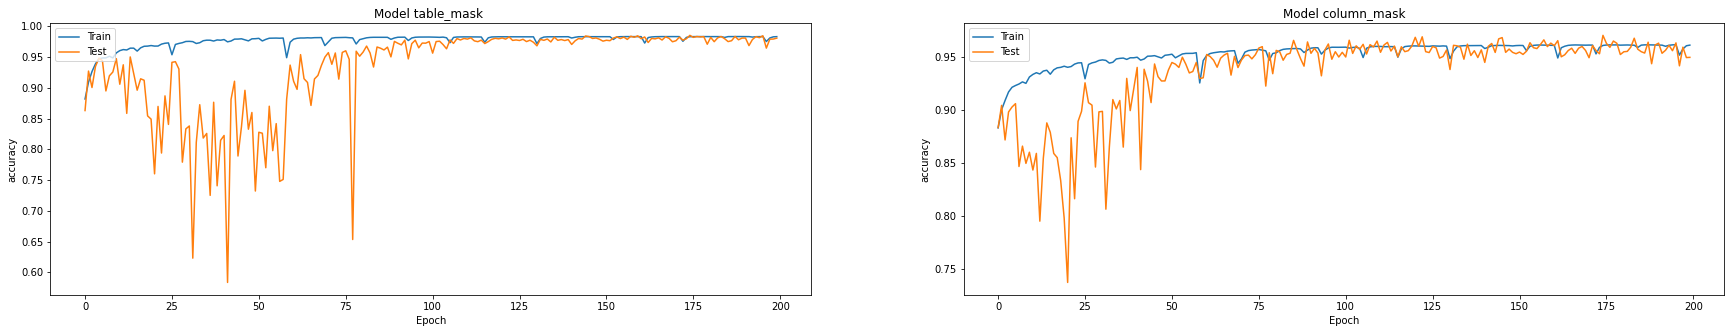

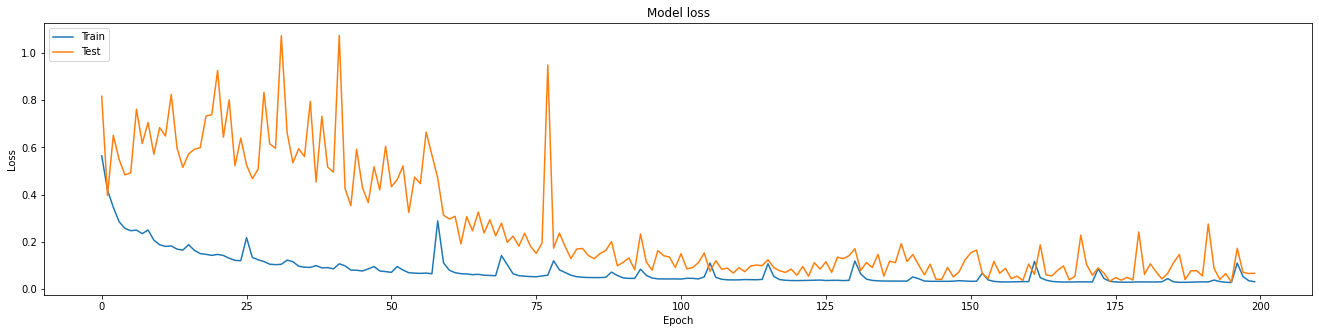

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(model_history.history['table_mask_accuracy'])
plt.plot(model_history.history['val_table_mask_accuracy'])
plt.title('Model table_mask ')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(model_history.history['column_mask_accuracy'])
plt.plot(model_history.history['val_column_mask_accuracy'])
plt.title('Model column_mask')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(50, 5))
plt.subplot(122)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [5]:
def masks(table_mask, column_mask):
  table_mask = tf.argmax(table_mask, axis=-1)
  table_mask = table_mask[..., tf.newaxis]


  column_mask = tf.argmax(column_mask, axis=-1)
  column_mask = column_mask[..., tf.newaxis]
  return table_mask[0], column_mask[0]

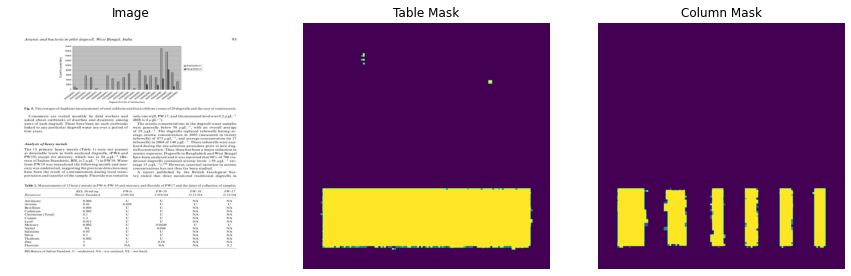

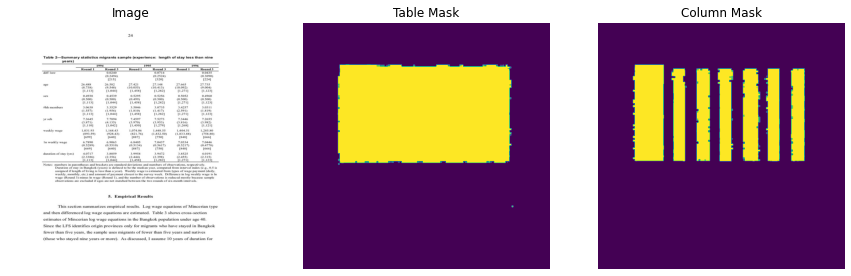

In [ ]:
import numpy as np
number = 2
for image, mask  in test_data.take(number):
  plt.figure(figsize=(15, 15))
  mask1, mask2 = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = masks(mask1, mask2)

  lists = [image, table_mask, column_mask]
  title = ['Image', 'Table Mask', 'Column Mask']         
  for i in range(len(lists)):
    plt.subplot(1, len(lists), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(lists[i]))
    plt.axis('off')
  plt.show()         

# Performance validated by Precision , Recall and F1-score 

In [ ]:
import numpy as np
table , column = list() , list()
predicted_table , predicted_column = list() , list()
for image, mask  in test_data:
  table.append(mask['table_mask'])
  column.append(mask['column_mask'])
  mask1_, mask2_ = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = masks(mask1_, mask2_)
  predicted_table.append(table_mask)
  predicted_column.append(column_mask)


In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/metrics
def recall(table, predicted_table):
  m = tf.keras.metrics.Recall()
  m.update_state(table, predicted_table)
  return m.result().numpy()

def precision(table, predicted_table):
  m = tf.keras.metrics.Precision()
  m.update_state(table, predicted_table)
  return m.result().numpy()  

def result(true , pred):
  Recall = recall(true, pred)
  Precision = precision(true, pred)
  f1 = 2*(Recall * Precision)/(Recall + Precision)
  print(f'Recall is {Recall}')
  print("-"*50)
  print(f'Precision is {Precision}')
  print("-"*50)
  print(f'f1_score is {f1}')


In [ ]:
#checking for table mask
result(table , predicted_table)

Recall is 0.9246924519538879
--------------------------------------------------
Precision is 0.9913131594657898
--------------------------------------------------
f1_score is 0.9568445592566738


In [ ]:
#checking for column mask
result(column , predicted_column)

Recall is 0.7703480124473572
--------------------------------------------------
Precision is 0.9876634478569031
--------------------------------------------------
f1_score is 0.865574093752545


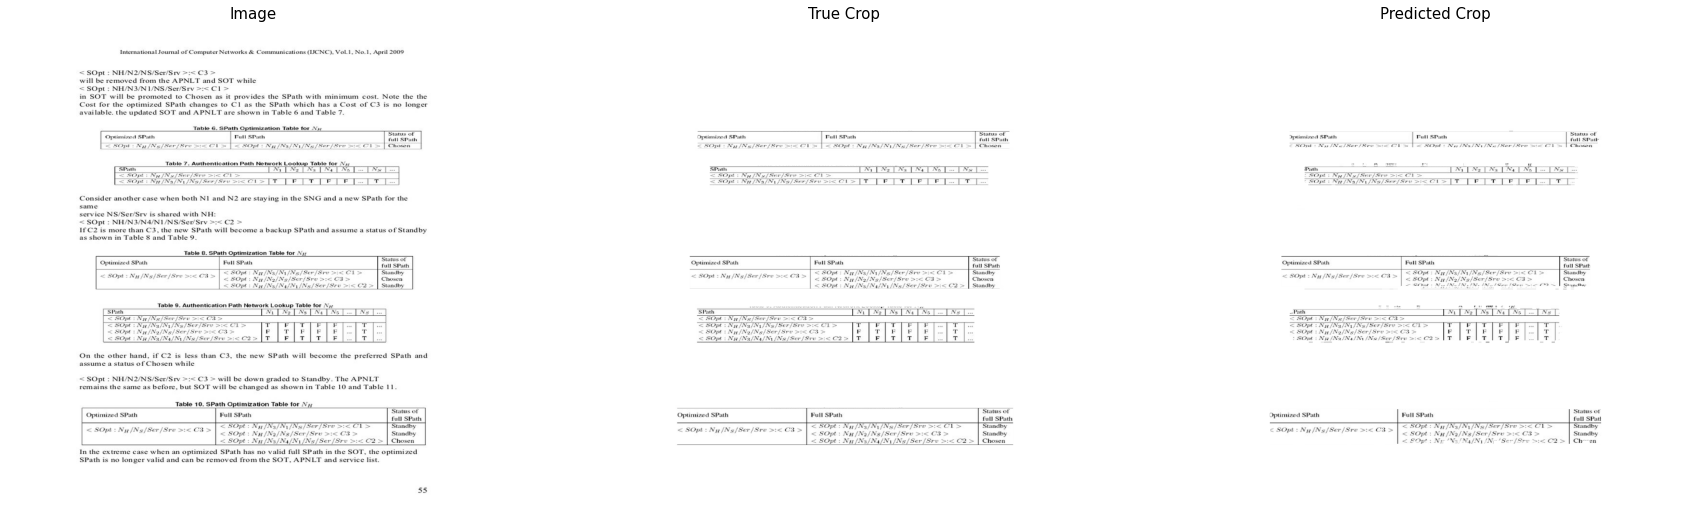

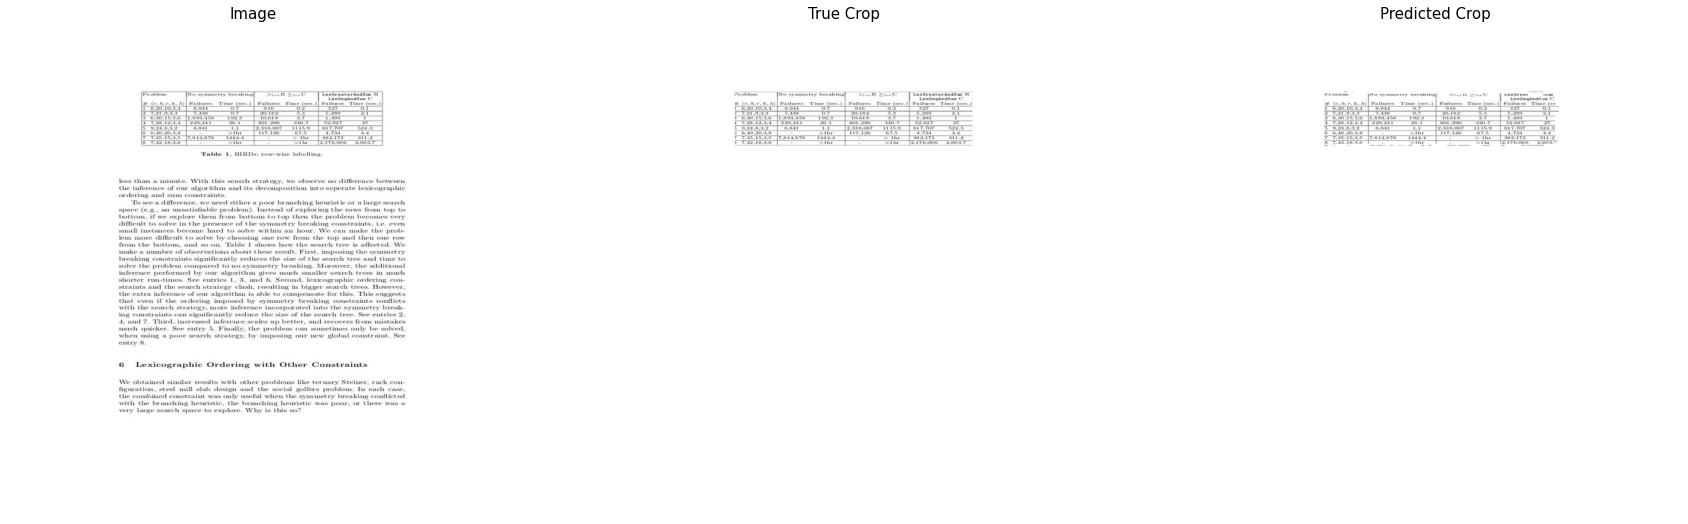

In [ ]:
#randomly comparing predicted output with actual output
number = 2
for image, mask  in test_data.take(number):
  plt.figure(figsize=(30, 50))

  true_table = mask['table_mask']
  true_table=tf.keras.preprocessing.image.array_to_img(true_table)
  true_table = true_table.convert('L')

  true_column = mask['column_mask']
  true_column=tf.keras.preprocessing.image.array_to_img(true_column)
  true_column = true_column.convert('L')


  mask1, mask2 = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = masks(mask1, mask2)

  pred_table = tf.keras.preprocessing.image.array_to_img(table_mask)
  pred_column = tf.keras.preprocessing.image.array_to_img(column_mask)
  pred_table = pred_table.convert('L')
  pred_column = pred_column.convert('L')


  title = ['Image', 'True Crop', 'Predicted Crop']         
  for i in range(len(title)): 
    plt.subplot(1, len(title), i+1)
    if i == 0:
      plt.title(title[i],fontsize=15)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
      plt.axis('off')

    elif i == 1:
      img = tf.keras.preprocessing.image.array_to_img(image)
      img.putalpha(true_table)
      #img.putalpha(true_column)
      plt.title(title[i],fontsize=15)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
      plt.axis('off')

    else:
      img = tf.keras.preprocessing.image.array_to_img(image)
      img.putalpha(pred_table)
      #img.putalpha(pred_column)
      plt.title(title[i],fontsize=15)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(img))  
      plt.axis('off')
  plt.show() 

# converting table image into text

In [ ]:
for image, mask in test_data.take(1):
  mask1, mask2 = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = masks(mask1, mask2)

  im=tf.keras.preprocessing.image.array_to_img(image)
  im.save('/content/content/MyDrive/table_extraction/img/image.bmp')
        
  im=tf.keras.preprocessing.image.array_to_img(table_mask)
  im.save('/content/content/MyDrive/table_extraction/table_mas/table_mask.bmp')
        
  im=tf.keras.preprocessing.image.array_to_img(column_mask)
  im.save('/content/content/MyDrive/table_extraction/column_mas/column_mask.bmp')

In [18]:
#ref: https://stackoverflow.com/questions/65523727/python-image-masking-and-removing-background?noredirect=1&lq=1


# loading image , table mask and column mask from predicted model 
image  = Image.open('/content/content/MyDrive/table_extraction/img/image.bmp')
table_mask = Image.open('/content/content/MyDrive/table_extraction/table_mas/table_mask.bmp')
column_column = Image.open('/content/content/MyDrive/table_extraction/column_mas/column_mask.bmp')

#converting table mask into grayscale
img_mask = img_mask.convert('L')    # grayscale


# add alpha channel    
image.putalpha(table_mask)

#saving image
image.save('output1.png')

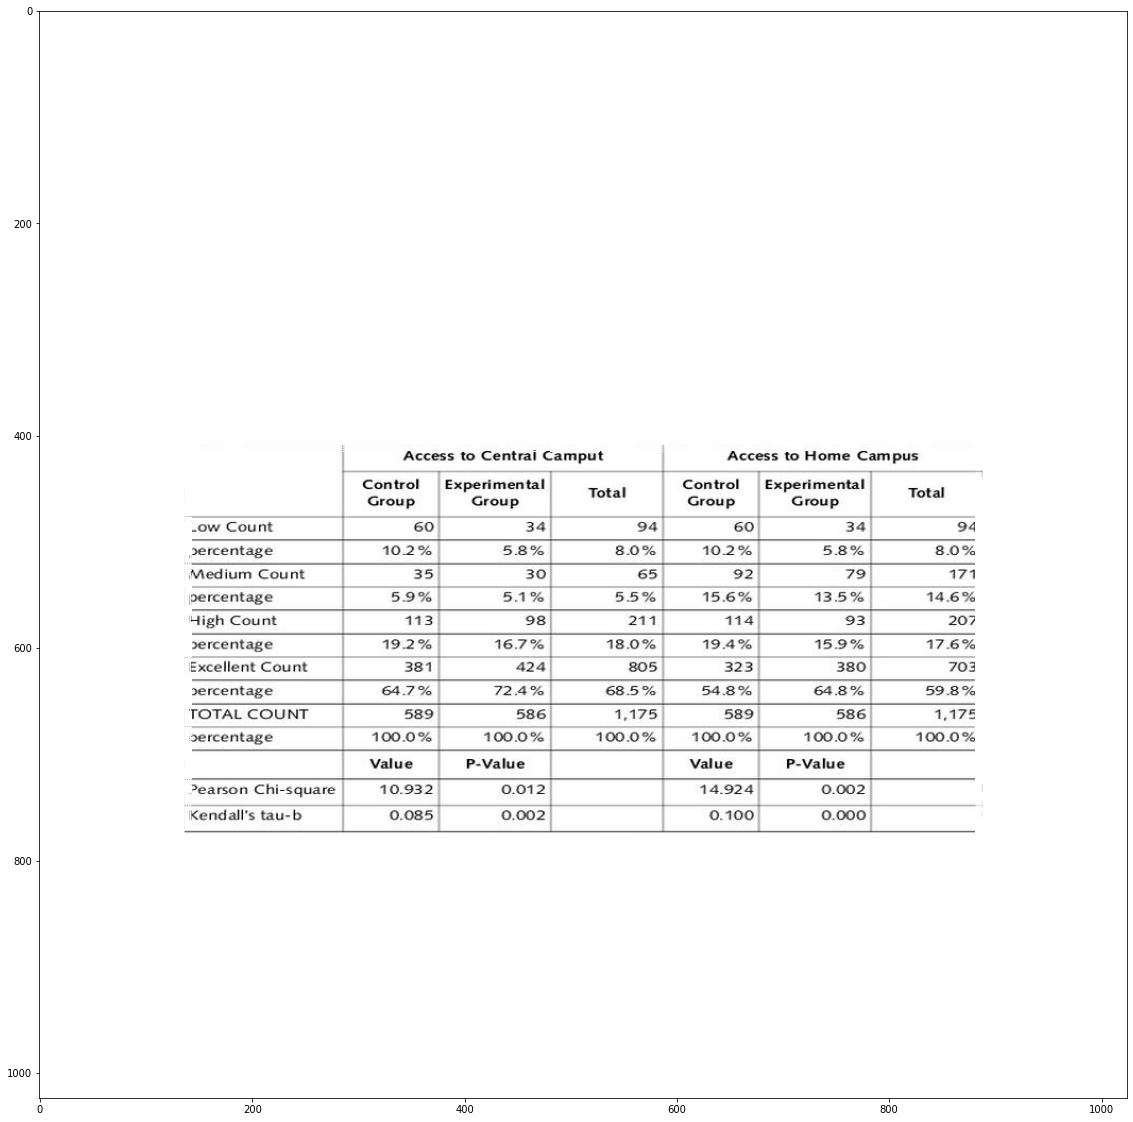

In [19]:
#showing output image 
image = cv2.imread('output1.png',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

In [1]:
#installing Pillow and pytesseract
!pip install Pillow
!pip install pytesseract

You should consider upgrading via the 'c:\users\dipaktiwari029\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\dipaktiwari029\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
import pytesseract
from PIL import ImageEnhance, ImageFilter, Image
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe" 

In [5]:
#creating function to input image path and in return we get text file 
def ocr_tesseract(filename):
    text = pytesseract.image_to_string(Image.open(filename))  
    return text

print(ocr_tesseract('output1.png'))

Access to Centrai Camput

Access to Home Campus

 

 

 

 

 

 

 

 

 

 

 

 

 

 

eed ee ee

Tow Count 1 60 34] 34 60] 3a] 34
bercentage [102% 58% 3.0% 102% 58%) 30%
Medium Count | 35 30) 65 92 79| 174
percentage 59% 51% 55% 15.6% 135% | 14.6%
4igh Count 113 98 211 114 93] (207
dercentage 19.2% 16.7% 18.0% 19.4% 15.9% | 17.6%
Excellent Count | 381 424] 805 323 380] 703
Jercentage CAT% 724% | 685% 548% 648% | 598%
TOTAL COUNT 589 586 589 586)
percentage [100.0% 100.0% | 100.0% 100.0% | 100.0%

| value P-value | Value P-value |
Searson Chi-square| 10.932 0.012 74.924 0.002
Kendall's tau-b 0.085 0.002 0.100 0.000)

 

 

 

 

 

